# Fraud Detection Using Neural Networks

This notebook aims to build and optimize a neural network for fraud detection using grid search for hyperparameter tuning. The key steps include data preprocessing, defining the neural network, training, hyperparameter tuning, and evaluation.


## Data Preprocessing

In [1]:
import numpy as np 
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import torch

# Read in data
data = pd.read_csv('fraud_oracle.csv')

# One hot encode categorical variables
categorical_cols = data.select_dtypes(include=['object']).columns
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Define target and feature variables
y = data['FraudFound_P'].values
X = data.drop('FraudFound_P', axis=1).values

# Normalize inputs
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

device = 'cpu'

# Convert to tensors and move to device
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)


## Initial Model Definition
Parameters (Will tune with GridSearch):
- input_dim: Number of input features.
- hidden_dim1=64: Number of neurons in the first hidden layer (default 64).
- hidden_dim2=32: Number of neurons in the second hidden layer (default 32).
- hidden_dim3=16: Number of neurons in the third hidden layer (default 16).

Layers:
- self.layer1: First linear layer.
- self.layer2: Second linear layer.
- self.layer3: Third linear layer.
- self.output: Output linear layer.

Forward Method:
- Applied ReLU activation to the outputs of the first, second, and third layers to introduce non-linearity.
- Applied Sigmoid activation to the output layer to output a probability between 0 and 1 for binary classification.


In [2]:
from torch import nn
from torch import optim

# Define network
class NeuralNetwork1(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=64, hidden_dim3=32):
        super(NeuralNetwork1, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim1)
        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.layer3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.output = nn.Linear(hidden_dim3, 1)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.sigmoid(self.output(x))  # Use sigmoid activation for binary classification
        return x

# Instantiate the model
model1 = NeuralNetwork1(X_train.shape[1]).to(device)

# Define the loss criterion
criterion = nn.BCELoss()  # for binary classification

# Define the optimizer
optimizer = optim.Adam(model1.parameters(), lr=1e-3)

In [3]:
# Train the model
epochs = 50
train_losses = []
val_losses = []
for epoch in range(epochs):
    model1.train()
    optimizer.zero_grad()
    outputs = model1(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    model1.eval()
    with torch.no_grad():
        val_outputs = model1(X_val)
        val_loss = criterion(val_outputs, y_val)
        val_losses.append(val_loss.item())
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [10/50], Loss: 0.5181
Epoch [20/50], Loss: 0.3083
Epoch [30/50], Loss: 0.2232
Epoch [40/50], Loss: 0.2133
Epoch [50/50], Loss: 0.1966


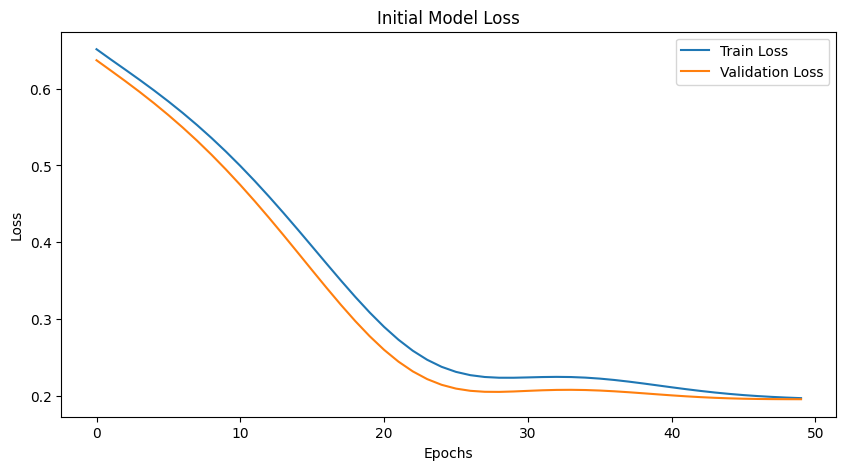

Train Accuracy: 0.9386
Validation Accuracy: 0.9455
Test Accuracy: 0.9475
Test Loss: 0.1882


In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Plotting the losses
plt.figure(figsize=(10,5))
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Initial Model Loss')
plt.show()

# Evaluate the model
model1.eval()
with torch.no_grad():
    train_outputs = model1(X_train)
    train_preds = (train_outputs > 0.5).float()
    val_outputs = model1(X_val)
    val_preds = (val_outputs > 0.5).float()

train_accuracy = accuracy_score(y_train.cpu().numpy(), train_preds.cpu().numpy())
val_accuracy = accuracy_score(y_val.cpu().numpy(), val_preds.cpu().numpy())

print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Evaluate the model on the test set
model1.eval()
with torch.no_grad():
    test_outputs = model1(X_test)
    test_preds = (test_outputs > 0.5).float()
    test_loss = criterion(test_outputs, y_test)

test_accuracy = accuracy_score(y_test.cpu().numpy(), test_preds.cpu().numpy())

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss.item():.4f}')

With this dataset there is a notable imbalance in the distribution of our target variable across all observations, we will use class weighting to combat this:

In [5]:
from sklearn.utils.class_weight import compute_class_weight

# Class distribution
class_distribution = data['FraudFound_P'].value_counts(normalize=True)
print("Class Distribution:")
print(class_distribution)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train.cpu().numpy().flatten())

# Convert class weights to a tensor and move to the appropriate device
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print(f"Class weights: {class_weights}")

Class Distribution:
FraudFound_P
0    0.940143
1    0.059857
Name: proportion, dtype: float64
Class weights: tensor([0.5327, 8.1372])


Epoch [10/50], Loss: 1.2525
Epoch [20/50], Loss: 1.1268
Epoch [30/50], Loss: 0.9662
Epoch [40/50], Loss: 0.7844
Epoch [50/50], Loss: 0.6155


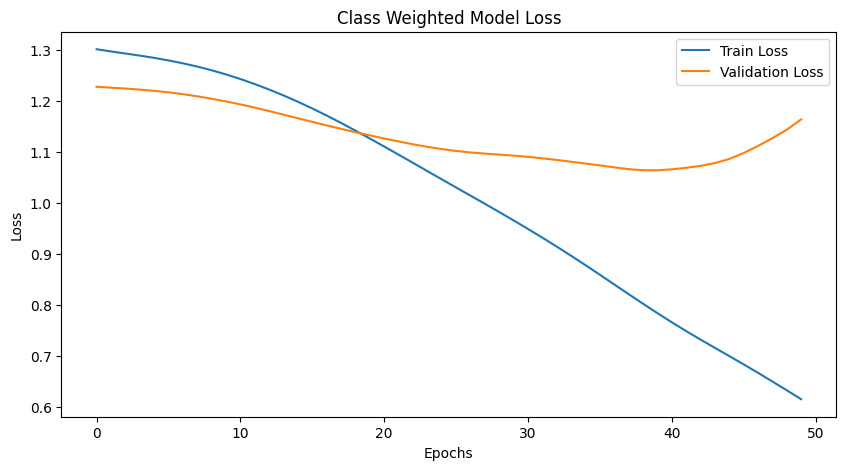

Train Accuracy: 0.8828
Validation Accuracy: 0.8320
Test Accuracy: 0.8366
Test Loss: 1.1288


In [6]:
# Redefine the network
class NeuralNetwork2(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=64, hidden_dim3=32):
        super(NeuralNetwork2, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim1)
        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.layer3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.output = nn.Linear(hidden_dim3, 1)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = self.output(x)  # No sigmoid here because BCEWithLogitsLoss includes it
        return x

# Reinstantiate model
model2 = NeuralNetwork2(X_train.shape[1]).to(device)
optimizer = optim.Adam(model2.parameters(), lr=1e-3)

# Define the loss criterion with class weights
criterion_weighted = nn.BCEWithLogitsLoss(pos_weight=class_weights[1] / class_weights[0])

# Train the model with class weights
epochs = 50
train_losses = []
val_losses = []
for epoch in range(epochs):
    model2.train()
    optimizer.zero_grad()
    outputs = model2(X_train)
    loss = criterion_weighted(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    model2.eval()
    with torch.no_grad():
        val_outputs = model2(X_val)
        val_loss = criterion_weighted(val_outputs, y_val)
        val_losses.append(val_loss.item())
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Plotting the losses
plt.figure(figsize=(10,5))
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Class Weighted Model Loss')
plt.show()

# Evaluate the model on training and validation sets
model2.eval()
with torch.no_grad():
    train_outputs = model2(X_train)
    train_preds = (train_outputs > 0.5).float()
    val_outputs = model2(X_val)
    val_preds = (val_outputs > 0.5).float()

train_accuracy = (train_preds == y_train).float().mean()
val_accuracy = (val_preds == y_val).float().mean()
print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Evaluate the model on the test set
with torch.no_grad():
    test_outputs = model2(X_test)
    test_preds = (test_outputs > 0.5).float()
    test_loss = criterion_weighted(test_outputs, y_test)

test_accuracy = (test_preds == y_test).float().mean()
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss.item():.4f}')


Interestingly the validation accuracy decreased and the loss increased with the addition of the weighted classes. Based off of the graph, it also seems we are overfitting to the training data. In order to try to remediate this we will implement focal loss. Focal loss is designed to handle class imbalance by down-weighting easy examples and focusing training on hard negatives, improving performance on imbalanced datasets (https://paperswithcode.com/method/focal-loss).

Epoch [10/50], Loss: 0.0254
Epoch [20/50], Loss: 0.0159
Epoch [30/50], Loss: 0.0149
Epoch [40/50], Loss: 0.0136
Epoch [50/50], Loss: 0.0130


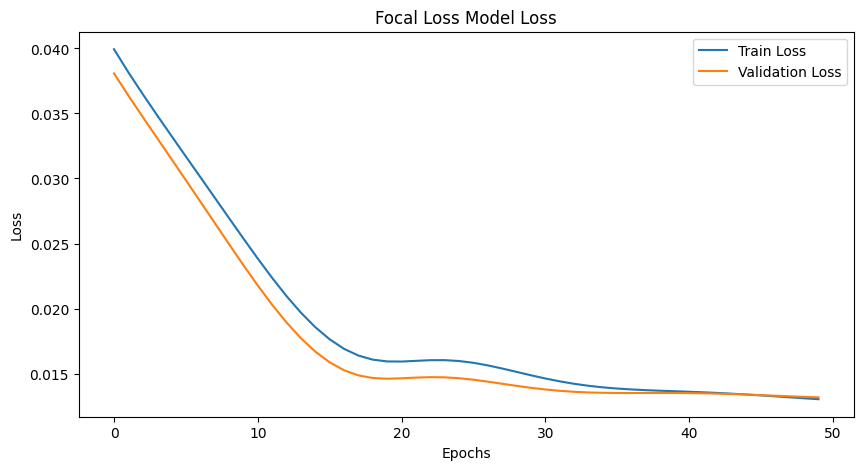

Train Accuracy: 0.9386
Validation Accuracy: 0.9455
Test Accuracy: 0.9475
Test Loss: 0.0128


In [7]:
import torch.nn.functional as F

# Redefine the network
class NeuralNetwork3(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=64, hidden_dim3=32):
        super(NeuralNetwork3, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim1)
        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.layer3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.output = nn.Linear(hidden_dim3, 1)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = self.output(x)  # No sigmoid here because BCEWithLogitsLoss includes it
        return x

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss.mean()

# Initialize Focal Loss
criterion_focal = FocalLoss(alpha=0.25, gamma=2)

# Re-initialize the model for training with Focal Loss
model3 = NeuralNetwork3(X_train.shape[1]).to(device)
optimizer = optim.Adam(model3.parameters(), lr=1e-3)

# Train the model with Focal Loss
train_losses = []
val_losses = []
epochs = 50
for epoch in range(epochs):
    model3.train()
    optimizer.zero_grad()
    outputs = model3(X_train)
    loss = criterion_focal(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    model3.eval()
    with torch.no_grad():
        val_outputs = model3(X_val)
        val_loss = criterion_focal(val_outputs, y_val)
        val_losses.append(val_loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

# Plotting the losses
plt.figure(figsize=(10,5))
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Focal Loss Model Loss')
plt.show()

# Evaluate the model
model3.eval()
with torch.no_grad():
    train_outputs = model3(X_train)
    train_preds = (train_outputs > 0.5).float()
    val_outputs = model3(X_val)
    val_preds = (val_outputs > 0.5).float()

train_accuracy = (train_preds == y_train).float().mean()
val_accuracy = (val_preds == y_val).float().mean()
print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Evaluate the model on the test set
with torch.no_grad():
    test_outputs = model3(X_test)
    test_preds = (test_outputs > 0.5).float()
    test_loss = criterion_focal(test_outputs, y_test)

test_accuracy = (test_preds == y_test).float().mean()
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss.item():.4f}')

[I 2024-06-08 15:49:02,860] A new study created in memory with name: no-name-891d0507-b2f3-46d2-b8da-438752d90cab
[I 2024-06-08 15:49:03,163] Trial 0 finished with value: 0.012707147747278214 and parameters: {'hidden_dim1': 52, 'hidden_dim2': 45, 'hidden_dim3': 16, 'lr': 0.005454300893540319}. Best is trial 0 with value: 0.012707147747278214.
[I 2024-06-08 15:49:03,534] Trial 1 finished with value: 0.013291366398334503 and parameters: {'hidden_dim1': 102, 'hidden_dim2': 28, 'hidden_dim3': 18, 'lr': 0.001186708445078566}. Best is trial 0 with value: 0.012707147747278214.
[I 2024-06-08 15:49:03,878] Trial 2 finished with value: 0.012705758213996887 and parameters: {'hidden_dim1': 57, 'hidden_dim2': 30, 'hidden_dim3': 24, 'lr': 0.001971024239568803}. Best is trial 2 with value: 0.012705758213996887.
[I 2024-06-08 15:49:04,233] Trial 3 finished with value: 0.013063102960586548 and parameters: {'hidden_dim1': 80, 'hidden_dim2': 33, 'hidden_dim3': 23, 'lr': 0.002016823893878463}. Best is tri

[I 2024-06-08 15:49:17,958] Trial 35 finished with value: 0.012923718430101871 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 47, 'hidden_dim3': 27, 'lr': 0.004948332479431171}. Best is trial 14 with value: 0.012227597646415234.
[I 2024-06-08 15:49:18,401] Trial 36 finished with value: 0.013484904542565346 and parameters: {'hidden_dim1': 122, 'hidden_dim2': 42, 'hidden_dim3': 17, 'lr': 0.0009301925892168126}. Best is trial 14 with value: 0.012227597646415234.
[I 2024-06-08 15:49:18,812] Trial 37 finished with value: 0.013415290042757988 and parameters: {'hidden_dim1': 89, 'hidden_dim2': 33, 'hidden_dim3': 31, 'lr': 0.007167146602640184}. Best is trial 14 with value: 0.012227597646415234.
[I 2024-06-08 15:49:19,295] Trial 38 finished with value: 0.01304143201559782 and parameters: {'hidden_dim1': 107, 'hidden_dim2': 36, 'hidden_dim3': 23, 'lr': 0.002206030841243706}. Best is trial 14 with value: 0.012227597646415234.
[I 2024-06-08 15:49:19,728] Trial 39 finished with value: 0.01295

Best hyperparameters:  {'hidden_dim1': 124, 'hidden_dim2': 38, 'hidden_dim3': 28, 'lr': 0.003906891275276613}
Epoch [10/50], Loss: 0.0160
Epoch [20/50], Loss: 0.0132
Epoch [30/50], Loss: 0.0117
Epoch [40/50], Loss: 0.0106
Epoch [50/50], Loss: 0.0094


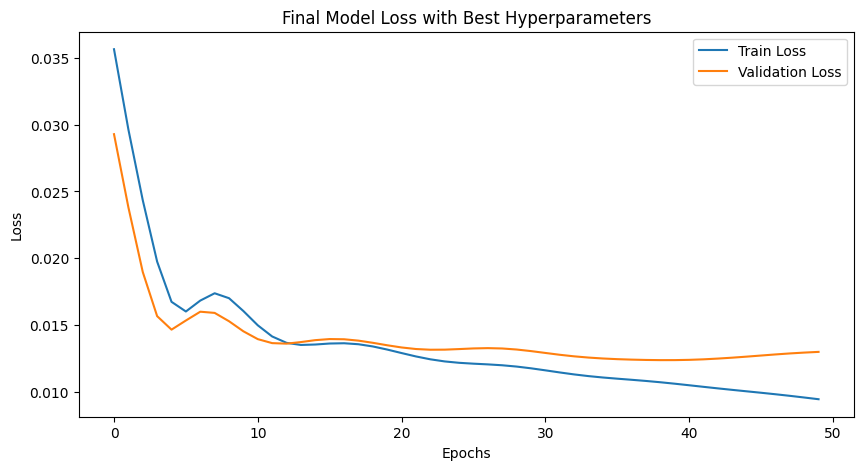

Train Accuracy: 0.9386
Validation Accuracy: 0.9455


In [8]:
import optuna
from torch import optim

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    hidden_dim1 = trial.suggest_int('hidden_dim1', 32, 128)
    hidden_dim2 = trial.suggest_int('hidden_dim2', 16, 64)
    hidden_dim3 = trial.suggest_int('hidden_dim3', 8, 32)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    
    # Instantiate the model
    model = NeuralNetwork3(X_train.shape[1], hidden_dim1, hidden_dim2, hidden_dim3).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Define the loss criterion
    criterion = FocalLoss(alpha=0.25, gamma=2)

    # Training loop
    epochs = 50
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
    
    return val_loss.item()

# Create study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print best hyperparameters
print('Best hyperparameters: ', study.best_trial.params)


# Train final model with best hyperparameters
best_params = study.best_trial.params
model = NeuralNetwork3(X_train.shape[1], best_params['hidden_dim1'], best_params['hidden_dim2'], best_params['hidden_dim3']).to(device)
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])
criterion = FocalLoss(alpha=0.25, gamma=2)

# Training loop for final model
epochs = 50
train_losses = []
val_losses = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        val_losses.append(val_loss.item())
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Plotting the losses for the final model
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Final Model Loss with Best Hyperparameters')
plt.show()

# Evaluate the final model
model.eval()
with torch.no_grad():
    train_outputs = model(X_train)
    train_preds = (train_outputs > 0.5).float()
    val_outputs = model(X_val)
    val_preds = (val_outputs > 0.5).float()

train_accuracy = accuracy_score(y_train.cpu().numpy(), train_preds.cpu().numpy())
val_accuracy = accuracy_score(y_val.cpu().numpy(), val_preds.cpu().numpy())

print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')

Epoch [10/50], Loss: 0.0157, Val Loss: 0.0145
Epoch [20/50], Loss: 0.0130, Val Loss: 0.0134
Epoch [30/50], Loss: 0.0117, Val Loss: 0.0130
Epoch [40/50], Loss: 0.0106, Val Loss: 0.0126
Early stopping at epoch 48


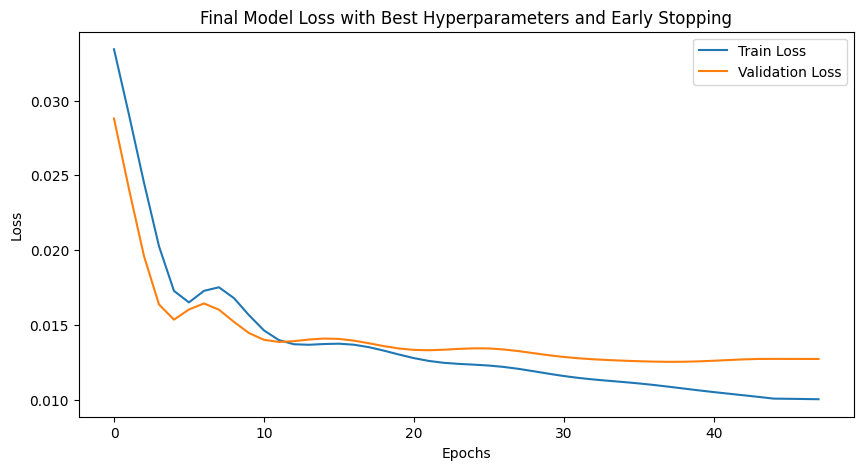

Train Accuracy: 0.9386
Validation Accuracy: 0.9455


In [9]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Initialize the model with best hyperparameters 
best_params = study.best_trial.params
model = NeuralNetwork3(X_train.shape[1], best_params['hidden_dim1'], best_params['hidden_dim2'], best_params['hidden_dim3']).to(device)
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)
criterion = FocalLoss(alpha=0.25, gamma=2)

# Train the model with early stopping and learning rate scheduler
epochs = 50
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0
patience = 10  # Number of epochs to wait before early stopping

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        val_losses.append(val_loss.item())
    
    # Scheduler step
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Load the best model state
model.load_state_dict(best_model_state)

# Plotting the losses for the final model
plt.figure(figsize=(10,5))
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Final Model Loss with Best Hyperparameters and Early Stopping')
plt.show()

# Evaluate the final model
model.eval()
with torch.no_grad():
    train_outputs = model(X_train)
    train_preds = (train_outputs > 0.5).float()
    val_outputs = model(X_val)
    val_preds = (val_outputs > 0.5).float()

train_accuracy = accuracy_score(y_train.cpu().numpy(), train_preds.cpu().numpy())
val_accuracy = accuracy_score(y_val.cpu().numpy(), val_preds.cpu().numpy())

print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')


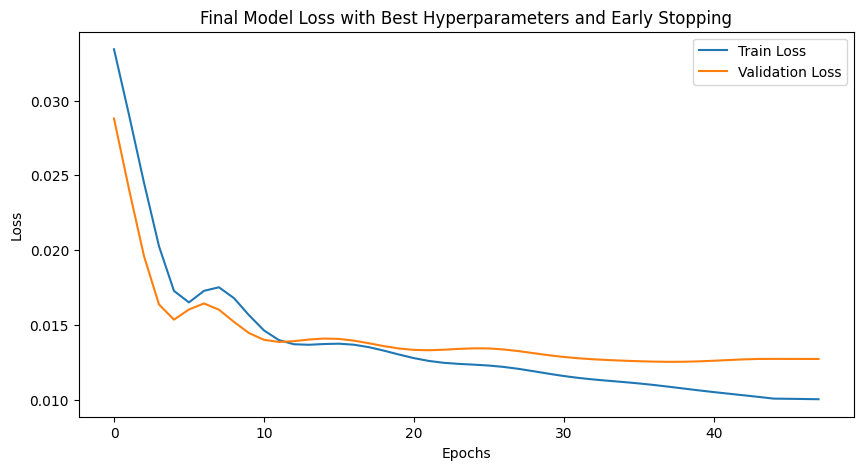

Validation Accuracy: 0.9455
Test Accuracy: 0.9475


In [10]:
# Training and evaluation code

# Load the best model state
model.load_state_dict(best_model_state)

# Plotting the losses for the final model
plt.figure(figsize=(10,5))
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Final Model Loss with Best Hyperparameters and Early Stopping')
plt.show()

# Evaluate the final model on the validation set
model.eval()
with torch.no_grad():
    val_outputs = model(X_val)
    val_preds = (val_outputs > 0.5).float()

val_accuracy = accuracy_score(y_val.cpu().numpy(), val_preds.cpu().numpy())
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Initialize the model architecture
model = NeuralNetwork3(X_train.shape[1], best_params['hidden_dim1'], best_params['hidden_dim2'], best_params['hidden_dim3']).to(device)
model.load_state_dict(best_model_state)
model.eval()  # Set the model to evaluation mode

# Evaluate the final model on the test set
with torch.no_grad():
    test_outputs = model(X_test)
    test_preds = (test_outputs > 0.5).float()

test_accuracy = accuracy_score(y_test.cpu().numpy(), test_preds.cpu().numpy())
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch [10/50], Loss: 0.0185, Val Loss: 0.0174
Epoch [20/50], Loss: 0.0135, Val Loss: 0.0143
Epoch [30/50], Loss: 0.0118, Val Loss: 0.0135
Early stopping at epoch 36


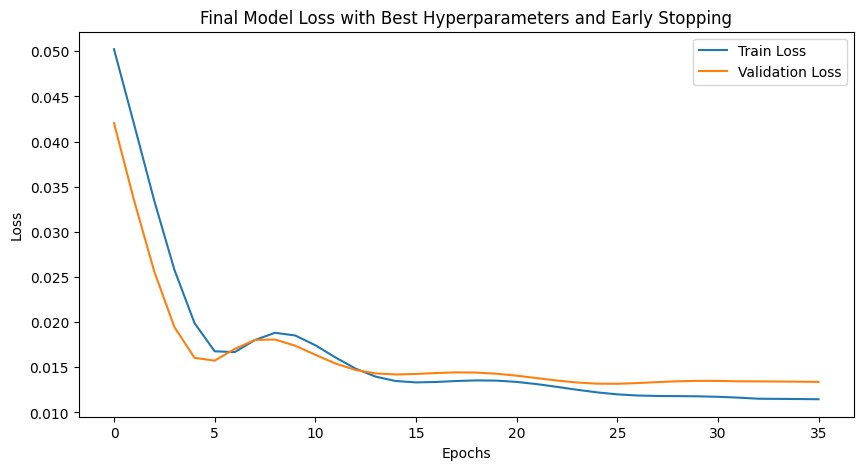

Test Accuracy: 0.9475


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Define the neural network class and FocalLoss as before

class NeuralNetwork3(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=64, hidden_dim3=32):
        super(NeuralNetwork3, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim1)
        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.layer3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.output = nn.Linear(hidden_dim3, 1)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = self.output(x)  # No sigmoid here because BCEWithLogitsLoss includes it
        return x

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss.mean()

# Initialize the model with best hyperparameters 
best_params = study.best_trial.params
model = NeuralNetwork3(X_train.shape[1], best_params['hidden_dim1'], best_params['hidden_dim2'], best_params['hidden_dim3']).to(device)
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)
criterion = FocalLoss(alpha=0.25, gamma=2)

# Train the model with early stopping and learning rate scheduler
epochs = 50
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0
patience = 10  # Number of epochs to wait before early stopping

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        val_losses.append(val_loss.item())
    
    # Scheduler step
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Save the entire model
model_save_path = 'models/best_neural_network_model.pth'
torch.save(model, model_save_path)

# Plotting the losses for the final model
plt.figure(figsize=(10,5))
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Final Model Loss with Best Hyperparameters and Early Stopping')
plt.show()

# Load the best model
loaded_model = torch.load(model_save_path)
loaded_model.eval()  # Set the model to evaluation mode

# Evaluate the final model on the test set
with torch.no_grad():
    test_outputs = loaded_model(X_test)
    test_preds = (test_outputs > 0.5).float()

test_accuracy = accuracy_score(y_test.cpu().numpy(), test_preds.cpu().numpy())
print(f'Test Accuracy: {test_accuracy:.4f}')
